Data source : https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import statsmodels.formula.api as smf

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import  roc_auc_score, accuracy_score, classification_report, confusion_matrix, auc , roc_curve , precision_recall_curve
from sklearn.model_selection import cross_val_predict, cross_val_score , train_test_split, cross_validate, StratifiedKFold, GridSearchCV


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [6]:
import graphviz 
import sklearn.tree as tree

In [7]:
df = pd.read_csv("diabetes_data_upload.csv")

In [8]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [9]:
df.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [10]:
pd.crosstab(df['Gender'], df['class'])

class,Negative,Positive
Gender,,
Female,19,173
Male,181,147


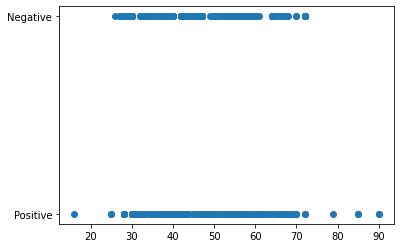

In [11]:
plt.scatter(df['Age'], df['class'])

In [12]:
df['class'].value_counts()

Positive    320
Negative    200
Name: class, dtype: int64

In [13]:
def make_num(val):
    if val == 'Positive':
        return 1
    else:
        return 0
    
df['class_num'] = df['class'].apply(lambda x: make_num(x))

In [14]:
df['class_num'].value_counts()

1    320
0    200
Name: class_num, dtype: int64

In [15]:
df.drop(['class'], axis = 1 , inplace =True)

In [16]:
cols = df.columns.tolist()

In [17]:
## format the column names
cols[4] = 'sudden_weight_loss'
cols[7] = 'Genital_thrush'
cols[8] = 'visual_blurring'
cols[11] = 'delayed_hearing'
cols[12] = 'partial_paresis'
cols[13] = 'muscle_stiffness'

In [18]:
cols

['Age',
 'Gender',
 'Polyuria',
 'Polydipsia',
 'sudden_weight_loss',
 'weakness',
 'Polyphagia',
 'Genital_thrush',
 'visual_blurring',
 'Itching',
 'Irritability',
 'delayed_hearing',
 'partial_paresis',
 'muscle_stiffness',
 'Alopecia',
 'Obesity',
 'class_num']

In [19]:
df.columns = cols

In [20]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden_weight_loss,weakness,Polyphagia,Genital_thrush,visual_blurring,Itching,Irritability,delayed_hearing,partial_paresis,muscle_stiffness,Alopecia,Obesity,class_num
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,1
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,1
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,1
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,1
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1


In [21]:
def perform_classification(model , X_train,X_test,y_train,y_test, classifier):
    
    model = model.fit(X_train,y_train)
    
    
    train_pred = model.predict(X_train)

    accuracy = np.mean(y_train == train_pred)
    print("Train Accuracy using predicted labels :" + str(accuracy))


    test_pred = model.predict(X_test)
    

    print("Test set score using predicted labels: {:.2f}".format(np.mean(test_pred == y_test)))

    print("Calculated Test set score: {:.2f}".format(model.score(X_test,y_test)))

    print("Accuracy score :{:.3f}".format(accuracy_score(y_test,test_pred)))

    print("Confusion matrix :\n{}".format(confusion_matrix(y_test,test_pred)))
    
    if classifier == 'dt':
            print("\n Max depth:{} ".format(model.tree_.max_depth))
        
    
    ## Calculate the AUC and plot the ROC curve.
    test_prob = model.predict_proba(X_test)
    preds = test_prob[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    ## Plot ROC curve.
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    ## Plot Variable importance for decision tree , random forest
    if (classifier == 'dt') | (classifier == 'rf') | (classifier == 'gbm'):
        plt.figure(figsize = (15,5))
        cols = X_train.columns.tolist()
        plt.bar(cols, model.feature_importances_)
        plt.xticks(rotation = 90)

    

In [22]:
## Hot encode the categorical variables .

def hot_encode(df, cols):
    ## Change the categorical columns to dummy variables . 
    
    for c in cols:
        col_dummies = pd.get_dummies(df[c], prefix_sep = "_", prefix = c)
        df = pd.concat([df,col_dummies] , axis = 1)
        df.drop(c , inplace = True , axis = 1)
    return df

In [23]:
cols

['Age',
 'Gender',
 'Polyuria',
 'Polydipsia',
 'sudden_weight_loss',
 'weakness',
 'Polyphagia',
 'Genital_thrush',
 'visual_blurring',
 'Itching',
 'Irritability',
 'delayed_hearing',
 'partial_paresis',
 'muscle_stiffness',
 'Alopecia',
 'Obesity',
 'class_num']

In [24]:
df_encoded = hot_encode(df[cols[:-1]], cols[1:-1])
X_train_val, X_test, y_train_val, y_test = train_test_split(df_encoded, df['class_num'], stratify = df['class_num'] , test_size = 0.2)
X_train, X_validate , y_train , y_validate = train_test_split(X_train_val , y_train_val , stratify = y_train_val, test_size = 0.25 )

print("\n X_train : {}".format(X_train.shape))
print("\n X_validate : {}".format(X_validate.shape))

print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_validate : {}".format(y_validate.shape))

print("\n y_test : {}".format(y_test.shape))



 X_train : (312, 31)

 X_validate : (104, 31)

 X_test : (104, 31)

 y_train : (312,)

 y_validate : (104,)

 y_test : (104,)


In [25]:
## Save  test data set as a futuristic sample 
test = X_test.copy()
test['class_num'] = y_test
test.to_csv("Diabetes_test.csv", index = False)

In [30]:
df_test = df.iloc[test.index]
df_test.to_csv("Diabetes_test_nonencoded.csv", index = False)

Train Accuracy using predicted labels :0.9230769230769231
Test set score using predicted labels: 0.94
Calculated Test set score: 0.94
Accuracy score :0.942
Confusion matrix :
[[39  1]
 [ 5 59]]


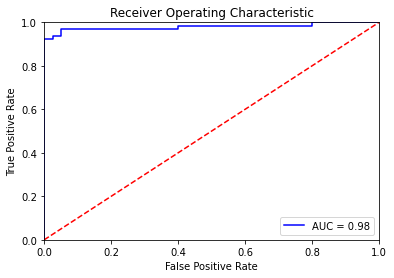

In [30]:
##
lg = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', random_state = 12)
perform_classification(lg , X_train,X_validate,y_train,y_validate , 'lg' )

In [33]:
X_validate.shape

(104, 31)

In [40]:
## combine train and validation data set for cross validation
predictors = pd.concat([X_train,X_validate])
target = pd.concat([y_train,y_validate])

In [57]:
## cross validate 

kf = StratifiedKFold(n_splits = 5, shuffle = True)
## Cross Validate with roc_auc as the metric 

lg  = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', random_state = 12)

scores = cross_val_score(lg, predictors , target, cv = kf, scoring = 'roc_auc' )
predicted_class = cross_val_predict(lg,predictors , target, cv = kf )
print(scores)
print("\n Avg AUC score :{}".format(scores.mean()))
print("Confusion matrix :\n{}".format(confusion_matrix(target,predicted_class)))

[0.99038462 0.96691176 0.96813725 0.96997549 0.95098039]

 Avg AUC score :0.9692779034690799
Confusion matrix :
[[153   7]
 [ 28 228]]


Train Accuracy using predicted labels :1.0
Test set score using predicted labels: 0.97
Calculated Test set score: 0.97
Accuracy score :0.971
Confusion matrix :
[[40  0]
 [ 3 61]]

 Max depth:9 


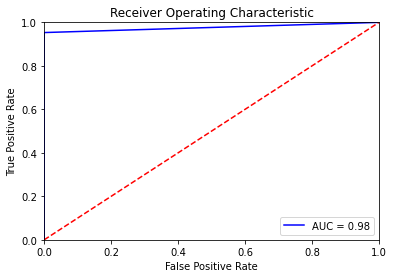

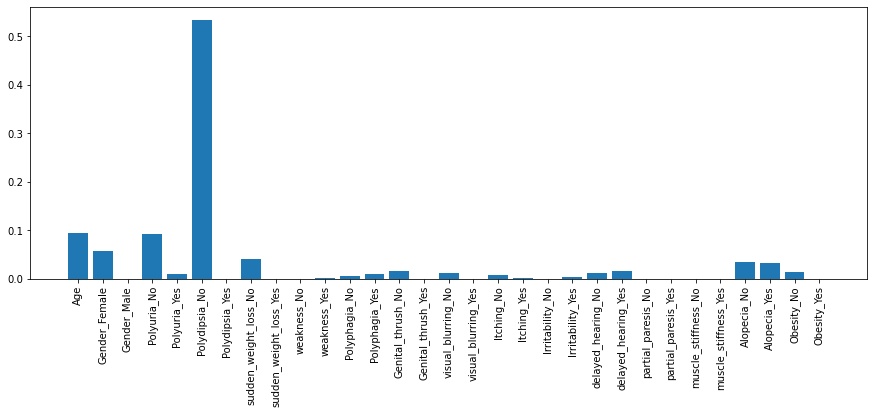

In [43]:
## Decision Tree Classifiucation
dt = DecisionTreeClassifier(random_state = 111, class_weight = 'balanced')
perform_classification(dt , X_train,X_validate,y_train,y_validate , 'dt' )

{'max_depth': 8, 'min_samples_split': 5}
Test set score using predicted labels: 0.98
Calculated Test set score: 0.98
Accuracy score :0.981
Confusion matrix :
[[40  0]
 [ 2 62]]


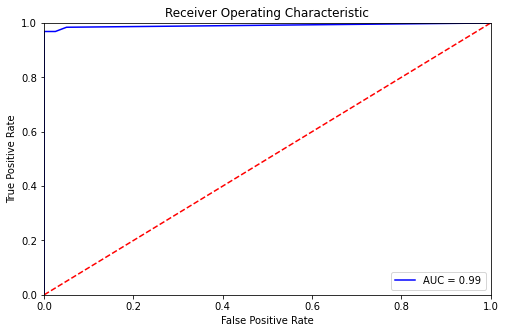

In [44]:
## GridsearchCV to tune the parameters of DT Classifier

param_grid = {
    'max_depth' : [2,4,6,8],
    'min_samples_split' : [2,5],
    }
dt = DecisionTreeClassifier(random_state = 111, class_weight = 'balanced')
## Stratified KFold 
cv = StratifiedKFold(random_state = 12, shuffle = True)
grid_search = GridSearchCV(dt, param_grid, cv=cv, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)
#
print(grid_search.best_params_)
#
dt_best = grid_search.best_estimator_
dt_predictions = dt_best.predict(X_validate)
#
print("Test set score using predicted labels: {:.2f}".format(np.mean(dt_predictions == y_validate)))

print("Calculated Test set score: {:.2f}".format(dt_best.score(X_validate,y_validate)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validate,dt_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validate,dt_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = dt_best.predict_proba(X_validate)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Train Accuracy using predicted labels :0.9839743589743589
Test set score using predicted labels: 0.98
Calculated Test set score: 0.98
Accuracy score :0.981
Confusion matrix :
[[40  0]
 [ 2 62]]

 Max depth:8 


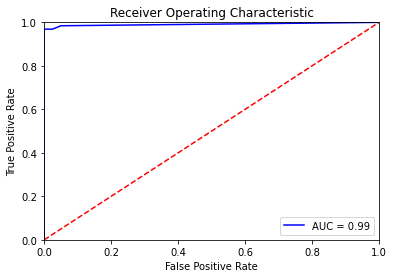

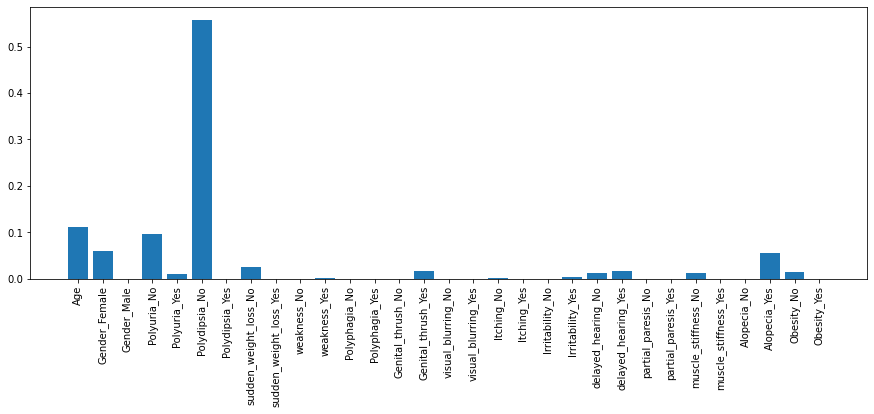

In [50]:
## Decision Tree Classification with the selected parameters 

dt = DecisionTreeClassifier(random_state = 111, class_weight = 'balanced', max_depth = 8,min_samples_split = 5)
perform_classification(dt , X_train,X_validate,y_train,y_validate , 'dt' )

In [55]:
## cross validate 
kf = StratifiedKFold(n_splits = 5, shuffle = True)
## Cross Validate with roc_auc as the metric 

dt = DecisionTreeClassifier(random_state = 111, class_weight = 'balanced',max_depth = 4)

scores = cross_val_score(dt, predictors , target, cv = kf, scoring = 'roc_auc' )
predicted_class = cross_val_predict(dt,predictors , target, cv = kf)

print(scores)
print("\n Avg AUC score :{}".format(scores.mean()))
print("Confusion matrix :\n{}".format(confusion_matrix(target,predicted_class)))

[0.9702524  0.92984069 0.99724265 0.92738971 0.9375    ]

 Avg AUC score :0.9524450886123681
Confusion matrix :
[[150  10]
 [ 23 233]]


Train Accuracy using predicted labels :1.0
Test set score using predicted labels: 0.98
Calculated Test set score: 0.98
Accuracy score :0.981
Confusion matrix :
[[39  1]
 [ 1 63]]


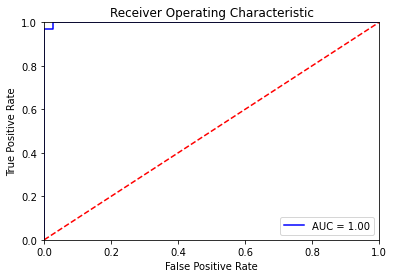

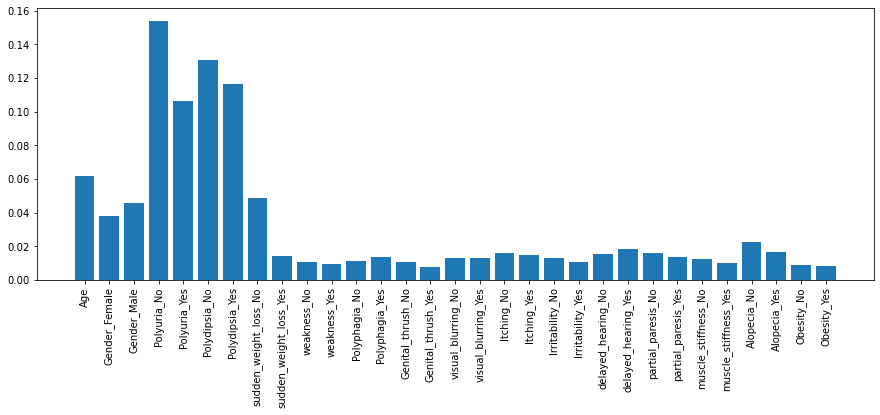

In [47]:
## Random Forest Classification

rf = RandomForestClassifier(random_state = 111, class_weight = 'balanced')
perform_classification(rf , X_train,X_validate,y_train,y_validate, 'rf' )


 Best parameters :
{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 200}
Test set score using predicted labels: 0.98
Calculated Test set score: 0.98
Accuracy score :0.981
Confusion matrix :
[[39  1]
 [ 1 63]]


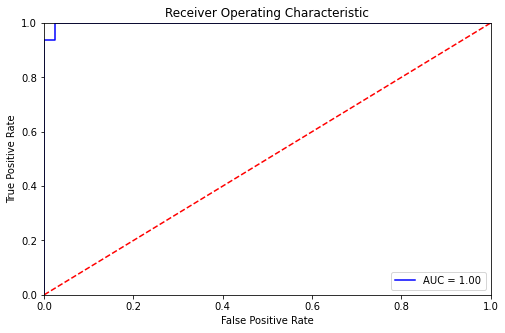

In [48]:
## GridsearchCV 

param_grid = {
    'max_depth' : [2,4,6,8],
    'min_samples_split' : [2,5],
    'n_estimators' : [100,200,500]
    }

## Stratified KFold 
cv = StratifiedKFold(random_state = 12, shuffle = True)
rf = RandomForestClassifier(random_state = 111, class_weight = 'balanced')
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)
#
print("\n Best parameters :")
print(grid_search.best_params_)
#
rf_best = grid_search.best_estimator_
rf_predictions = rf_best.predict(X_validate)
#
print("Test set score using predicted labels: {:.2f}".format(np.mean(rf_predictions == y_validate)))

print("Calculated Test set score: {:.2f}".format(rf_best.score(X_validate,y_validate)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validate,rf_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validate,rf_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = rf_best.predict_proba(X_validate)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Train Accuracy using predicted labels :1.0
Test set score using predicted labels: 0.98
Calculated Test set score: 0.98
Accuracy score :0.981
Confusion matrix :
[[39  1]
 [ 1 63]]


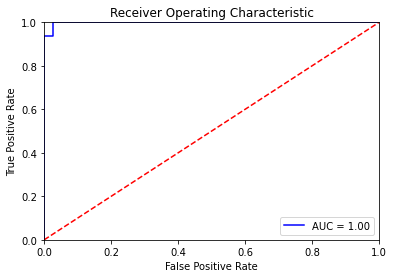

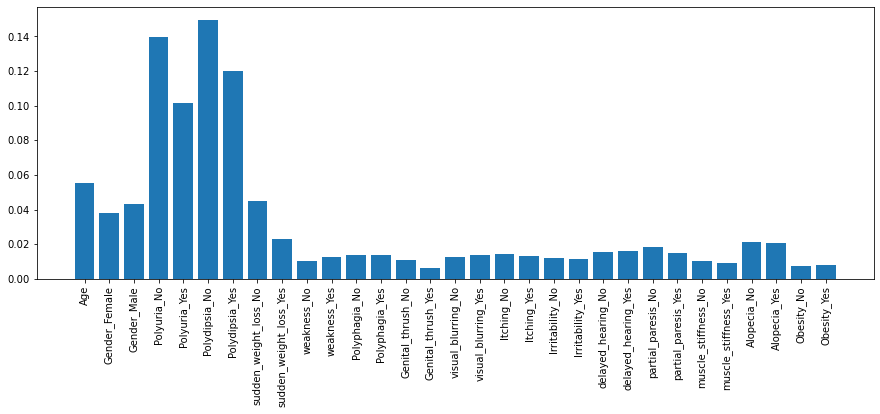

In [51]:
## Random Forest Classification with the selected parameters 

rf = RandomForestClassifier(random_state = 111, class_weight = 'balanced', max_depth = 8 , n_estimators = 200)
perform_classification(rf , X_train,X_validate,y_train,y_validate, 'rf' )

In [53]:
## cross validate 
kf = StratifiedKFold(n_splits = 5, shuffle = True)
## Cross Validate with roc_auc as the metric 

rf = RandomForestClassifier(random_state = 111, class_weight = 'balanced', max_depth = 8 , n_estimators = 200)

scores = cross_val_score(rf, predictors , target, cv = kf, scoring = 'roc_auc' )
predicted_class = cross_val_predict(dt,predictors , target, cv = kf )
print(scores)
print("\n Avg AUC score :{}".format(scores.mean()))
print("Confusion matrix :\n{}".format(confusion_matrix(target,predicted_class)))

[1.         1.         0.99693627 0.99387255 1.        ]

 Avg AUC score :0.9981617647058825
Confusion matrix :
[[154   6]
 [ 14 242]]


Best Performance is given by Random Forest Classifier. Variables that are important and help in classification are Gender, Polyuria, Polydipsia, Age.   

In [59]:
rf.fit(X_validate, y_validate)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=200,
                       random_state=111)

In [60]:
import pickle 
## save the model so that the model can be used for predicting new records that can be uploaded on a web app .  
pickle.dump(rf, open('diabetes_prediction_model.sav', 'wb'))
